**Lab 4** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Machine Learning for Audio and Acoustic Engineering***
---

# **Before you start**

*   Go to "*File*" --> "*Save a copy in Drive*"
*   Open that copy (might open automatically)
*   Then continue below

# **Lab 4: Neural Networks (II)**
---

In this lab we will continue exploring different types of deep architectures for audio processing, and we will pay special attention to system evaluation.


In [1]:
# As always, we import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.style.use("seaborn-v0_8")

### **Exercise 1**: Data Preparation I

We will continue working with the ESC-50 dataset. Download it to your notebook following the same steps as in Lab 2 and Lab 3.

In [ ]:
# !wget https://github.com/karolpiczak/ESC-50/archive/master.zip
# !unzip master.zip

--2025-05-07 13:57:43--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-05-07 13:57:43--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'master.zip'

     0K .......... .......... .......... .......... .......... 1.47M
    50K .......... .......... .......... .......... .......... 2.66M
   100K .......... .......... .......... .......... .......... 28.6M
   150K .......... .......... .......... .......... .......... 1.53M
   200K .......... ..

Create a list containing the audio files and another one with the corresponding labels (as in Lab 3):

In [20]:
audiofiles = [str(file) for file in Path('ESC-50-master/audio').glob('*.wav')]
labels = []
for i,file in enumerate(audiofiles):
  fileid = file.split('.wav')[-2]
  target = fileid.split('-')[-1]
  labels.append(int(target))


Instead of working with 50 classes, we limit our dataset to only 10 classes. Filter you two files (the one with file paths and the one with labels) to contain only those belonging to classes [0-9].

In [21]:
files = [audiofiles[i] for i,l in enumerate(labels) if l<10]
labels = [l for l in labels if l<10]

We load the signals and get the Mel spectrogram for each signal. Create a list called "signals" storing the raw waveforms of each file in your list and another one called "melspecs" that stores the Mel spectrogram for each signal.

Note: use the default parameters for librosa.load (resample to 22050Hz) and librosa.feature.melspectrogram.

In [ ]:
signals = [librosa.load(file, sr=22050)[0] for file in files]
melspecs = [librosa.feature.melspectrogram(y=signal, sr=22050) for signal in signals]

### **Exercise 2**: Data preparation II



Convert your "melspecs" and "labels" list to numpy arrays, called "Xdata" and "Ydata". 
Check that the result has size (400, 128, 216) for Xdata and (400,) for Ydata.

In [ ]:
Xdata = np.asarray(melspecs)
Ydata = np.asarray(labels)

print('Xdata shape: {} \nYata shape: {}'.format(Xdata.shape, Ydata.shape))

Xdata shape: (400, 128, 216) 
Yata shape: (400,)


Check that Ydata is balanced by plotting the histogram.

(400,)


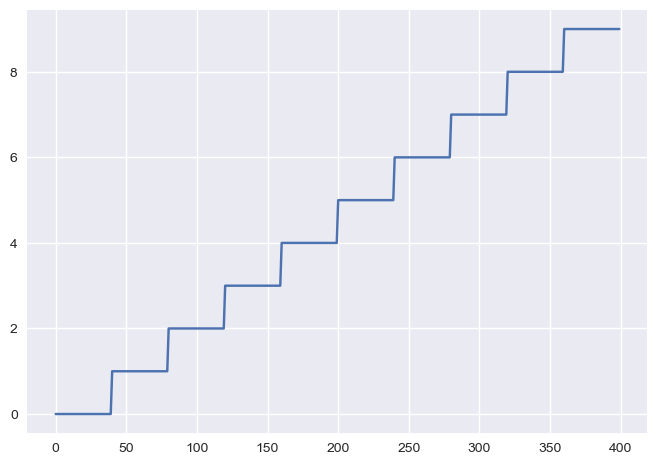

In [28]:
#Ydata, class distribution is balanced
sorted=np.sort(Ydata)
print(sorted.shape)
plt.plot(sorted)

Split your dataset into 3 partitions, 1 for training (70%), 1 for validation (20%) and 1 for test (10%). Check that the resulting arrays have the correct shape:

In [35]:
from sklearn.model_selection import train_test_split

# Split parameters
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 1234

# Calculate split ratios
a = np.round((1.0 - train_size), 2)
b = np.round(test_size/(test_size + val_size), 2)

# First split: train and temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(Xdata, Ydata, test_size=a, random_state=seed, shuffle=True, stratify=Ydata)
# Second split: val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=b, random_state=seed, shuffle=True, stratify=y_temp)
     
# Shapes for each partition
print('X_train shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))


X_train shape: (280, 128, 216) 
X_val shape: (80, 128, 216) 
X_test shape: (40, 128, 216) 
y_train shape: (280,) 
y_val shape: (80,) 
y_test shape: (40,) 



Expected output:
```
X_train shape: (280, 128, 216) 
X_val shape: (80, 128, 216) 
X_test shape: (40, 128, 216) 
y_train shape: (280,) 
y_val shape: (80,) 
y_test shape: (40,) 
```

In the next exercise we will create a time-distributed 1D-CNN to process our dataset. By default, Keras assumes that the last dimension corresponds to the number of channels in our input. Since we are going to use 1D-CNN, each frequency band will be processed as an independent frequency channel. Therefore, we need to reorder the dimensions in our data to move the frequency channels to the last dimension.

Use the numpy function "moveaxis" to create the data matrices X_train_rs, X_val_rs and X_test_rs, with dimensions (280, 216, 128), (80, 216, 128) and (40, 216, 128):

In [ ]:
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

print('X_train_rs shape: {} \nX_val_rs shape: {} \nX_test_rs shape: {}'.format(X_train_rs.shape, X_val_rs.shape, X_test_rs.shape))

X_train_rs shape: (280, 216, 128) 
X_val_rs shape: (80, 216, 128) 
X_test_rs shape: (40, 216, 128)


Expected output:
```
X_train_rs shape: (280, 216, 128) 
X_val_rs shape: (80, 216, 128) 
X_test_rs shape: (40, 216, 128)
```

### **Exercise 3**: 1D-Convolutional Neural Network



Create the following 1D-CNN architecture with Keras:

1. **Input**  Shape: `(timesteps, features)`

2. **Conv1D**  `16 filters, kernel=9, ReLU`

3. **MaxPool1D**  `Pool=2, padding=same`

4. **BatchNorm**

5. **Conv1D**  `16 filters, kernel=3, ReLU`

6. **MaxPool1D**  `Pool=2, padding=same`

7. **BatchNorm**

8. **Conv1D**  `32 filters, kernel=3, ReLU`

9. **MaxPool1D**  `Pool=2, padding=same`

10. **BatchNorm**

11. **Flatten**

12. **Dense**  `32 units, ReLU`

13. **Dense**  `10 units, Softmax`


In [ ]:
#create a convolutional structure
input_shape = (X_train_rs.shape[1], X_train_rs.shape[2]) 
print('INPUT SHAPE: ', input_shape)
model = tf.keras.models.Sequential()
#1st Conv layer
model.add(tf.keras.layers.Conv1D(16, 9, activation='relu',input_shape=input_shape, name='CONV1'))
model.add(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP1'))
model.add(tf.keras.layers.BatchNormalization(name='BATCH1'))
#2nd Conv layer
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu', name='CONV2'))
model.add(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP2'))
model.add(tf.keras.layers.BatchNormalization(name='BATCH2'))
#3rd Conv layer
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', name='CONV3'))
model.add(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP3'))
model.add(tf.keras.layers.BatchNormalization(name='BATCH3'))
#flat the output, thus i can feed it to a dense layer
model.add(tf.keras.layers.Flatten(name='FLATTEN'))
model.add(tf.keras.layers.Dense(32, activation='relu', name='DENSE'))
#model.add(tf.keras.layers.Dropout(0.5))
#output layer
model.add(tf.keras.layers.Dense(10, activation='softmax', name='SOFTMAX')) #10 output classes
model.summary()

INPUT SHAPE:  (216, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv1D)              (None, 208, 16)           18448     
                                                                 
 MP1 (MaxPooling1D)          (None, 104, 16)           0         
                                                                 
 BATCH1 (BatchNormalization)  (None, 104, 16)          64        
                                                                 
 CONV2 (Conv1D)              (None, 102, 16)           784       
                                                                 
 MP2 (MaxPooling1D)          (None, 51, 16)            0         
                                                                 
 BATCH2 (BatchNormalization)  (None, 51, 16)           64        
                                                                 
 CONV3 (Conv1D)              (N

Iniatialize Keras Callbacks:

*   CSVLogger.
*   Early_Stop with patience 100 epochs, working on validation loss.
*   ModelCheckpoint working on validation accuracy (monitor = 'val_accuracy').

In [38]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

#for csv logger
log_file_path = '1D_CNN_Classifier_training.log'
csv_logger = CSVLogger(log_file_path, append=False)

#for early stopping
patience = 100
early_stop = EarlyStopping('val_loss', patience = patience)

#for model checkpoint
model_name = '1D_CNN_Classifier.hdf5'
model_checkpoint = ModelCheckpoint(filepath = model_name, monitor = 'val_accuracy', verbose = 1, save_best_only = True) 

#we store all these callbacks in a list, Callback list
callbacks = [model_checkpoint, csv_logger, early_stop]

Train the network using Adam optimizer with `learning_rate=0.001` and a `batch_size=32`. Remember to include the created callbacks.

In [ ]:

X_train_rs.shape

(280, 216, 128)

From the log file, using pandas, plot the training history including accuracy and loss. What is your best validation accuracy?

ANSWER HERE!

Evaluate the model over the test dataset. What is your test accuracy? Is it better or worse than the one in your validation set?

In [62]:
# YOUR CODE HERE!

ANSWER HERE!

Now restore the best weights using `model.load_weights` and evaluate again. Discuss the obtained results.

In [ ]:
# YOUR CODE HERE!

DISCUSSION HERE!

### **Exercise 4**: 1D-CNN Evaluation

Plot your confusion matrix for the validation set and for your test set. Discuss the obtained results.

In [ ]:
# YOUR CODE HERE!

DISCUSSION HERE!

### **Exercise 5**: Time-Distributed 1D-CNN

In the previous 1D-CNN, each band of the Mel-spectrogram was treated as an independent channel. We want to continue using a similar 1D-CNN architecture but this time using a time-distributed model. Now the input will have several time steps (frames in this case) and 1 single channel.

Reshape your input X_train_rs to create a new input X_train_rss with dimensions (280, 216, 128, 1). You can use numpy's expand_dims.

In [ ]:
# YOUR CODE HERE!
X_train_rss = ...
X_val_rss = ...
X_test_rss = ...

print(f'Original size X_train_rs.shape=', X_train_rs.shape, '; X_val_rs.shape=', X_val_rs.shape, '; X_test_rs.shape=', X_test_rs.shape)
print(f'New size X_train_rss.shape=X_train_rss.shape', X_train_rss.shape, '; X_val_rss.shape=', X_val_rss.shape, '; X_test_rss.shape=', X_test_rss.shape) 

Original size X_train_rs.shape= (280, 216, 128) ; X_val_rs.shape= (80, 216, 128)
New size X_val_rss.shape=X_train_rss.shape (80, 216, 128, 1) ; X_val_rss.shape= (40, 216, 128, 1)


Expected output:
```
Original size X_train_rs.shape= (280, 216, 128) ; X_val_rs.shape= (80, 216, 128) ; X_test_rs.shape= (40, 216, 128)
New size X_train_rss.shape=X_train_rss.shape (280, 216, 128, 1) ; X_val_rss.shape= (80, 216, 128, 1) ; X_test_rss.shape= (40, 216, 128, 1)
```

Create your time-distributed network. A good thing of time-distributed networks is that the time-step dimension does not have to be fixed (it can be None). Thus, you can specify your input shape as:

input_shape = (None, 128, 1)



In [ ]:
#Create a time distributed model
...
modeltd.summary()

Train the model using the same callbacks as before.

In [ ]:
# YOUR CODE HERE!

Plot the training history and the best validation accuracy result. 

In [64]:
# YOUR CODE HERE!

Load the optimal weights (from early stopping) and plot the validation and test confusion matrices:

In [ ]:
# YOUR CODE HERE!

Discuss the obtained results.

### **Exercise 6**: Performance metrics

Use sklearn "classification_report" to analyze the performance of the classifier for each class in terms of Precision, Recall and F1.

Show the classification report for validation set. Discuss the results.

In [ ]:
# YOUR CODE HERE!

DISCUSSION HERE!

Show the classification report for the test set. Discuss the results.

In [ ]:
# YOUR CODE HERE!

DISCUSSION HERE!

### **Exercise 7**: Hybrid CNN-RNN

In this last exercise we are going to mix our previous time-distributed model with a LSTM layer to create a Hybrid CNN-RNN architecture.

Adapt your previous time-distributed model to match the following summary:

In [ ]:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   

# Time-Dist Conv1D             (None, None, 120, 16)     160       
# _________________________________________________________________
# Time-Dist MaxPool1D 1D       (None, None, 60, 16)      0         
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 60, 16)      0         
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 58, 16)      784       
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 29, 16)      0         
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 29, 16)      0         
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 27, 32)      1568      
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 27, 32)      0         
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 14, 32)      0         
# _________________________________________________________________
# Time-Dist Flatten            (None, None, 448)         0         
# _________________________________________________________________
# LSTM  (16 neurons)           (None, None, 16)          29760     
# _________________________________________________________________
# Global Av. Pooling 1D        (None, 16)                0         
# _________________________________________________________________
# Dropout (0.35)               (None, 16)                0         
# _________________________________________________________________
# Dense                        (None, 10)                170       

# Total params: 32,442
# Trainable params: 32,442
# Non-trainable params: 0
# _________________________________________________________________


In [65]:
#Create a time distributed model HERE!

Train the network using the same procedure as in previous tasks.

In [ ]:
# YOUR CODE HERE!

Plot the training history and evaluate the model using the optimal weights (from early stopping). 

NOTE: For the evaluation, compare the validation/test loss and accuracy, display the confusion matrices and show the classification reports.
Discuss your results.

In [66]:
# YOUR CODE HERE!

DISCUSSION HERE!

### **Exercise 8**: 2D CNN Experiment

Now, lets repeat the experiments but using a 2D CNN approach with the following proposed structure:

```
1.	Conv2D (16 filters, 3×3, ReLU, same padding)
2.	MaxPooling2D (2×2, same padding)
3.	BatchNormalization
4.	Conv2D (16 filters, 3×3, ReLU, same padding)
5.	MaxPooling2D (2×2, same padding)
6.	BatchNormalization
7.	Conv2D (32 filters, 3×3, ReLU, same padding)
8.	MaxPooling2D (2×2, same padding)
9.	BatchNormalization
10.	Flatten
11.	Dense (32 units, ReLU)
12.	Dense (10 units, Softmax) → Final classification layer for 10 classes
```

Develop the model, train it, evaluate it and discuss the results using the same procedure than in previous tasks:

In [ ]:
# YOUR CODE HERE!

DISCUSSION HERE!